This notebook focuses on the analysis of the Cyclistic case study in the Google Data Analytics certificate. Cyclistic is a fictional bike-sharing company based in Chicago. The company boasts a fleet of more than 5000 bikes and 700 stations across Chicago. Customers are able to make use of the service by buying single-ride passes, full-day passes or annual memberships. Customers holding single-ride or full-day passes are called 'casual riders' while those holding annual memberships are known as 'Cyclistic members'. The company's financial analysts have concluded that annual members are more profitable compared to casual riders. Instead of focusing on attracting new members to grow the company, upper management has decided to focus on maximizing the number of annual members by encouraging casual riders to acquire memberships. The aim of this project is to elucidate the differences in bike usage between casual riders and members and design marketing strategies to convert casual riders to members.

I will use SQL and Tableau for analysis and visualizations as I'm already able to produce the same results on R. I could have used SQL to merge all datasets together before using SQL Server Management Studio to export it to a .csv file and used Tableau to continue the analysis, but I wanted more experience in SQL so tasks like creating summary tables were done on SQL as well. The first order of business is to load in all data sets and merge all of them into 1 table.

<u>Three main questions will guide the analysis:</u>

- How do annual members and casual riders use Cyclistic bikes differently?
- Why would casual riders buy Cyclistic memberships?
- How can Cyclistic use digital media to influence casual riders to become members?

In [ ]:
-- This cell merges all tables into one.
USE Cyclistic;

DROP TABLE IF EXISTS merged

    SELECT *
    INTO merged
    FROM Cyclistic..[2021-09 tripdata]
UNION
    SELECT *
    FROM Cyclistic..[2021-10 tripdata]
UNION
    SELECT *
    FROM Cyclistic..[2021-11 tripdata]
UNION
    SELECT *
    FROM Cyclistic..[2021-12 tripdata]
UNION
    SELECT *
    FROM Cyclistic..[2022-01 tripdata]
UNION
    SELECT *
    FROM Cyclistic..[2022-02 tripdata]
UNION
    SELECT *
    FROM Cyclistic..[2022-03 tripdata]
UNION
    SELECT *
    FROM Cyclistic..[2022-04 tripdata]
UNION
    SELECT *
    FROM Cyclistic..[2022-05 tripdata]
UNION
    SELECT *
    FROM Cyclistic..[2022-06 tripdata]
UNION
    SELECT *
    FROM Cyclistic..[2022-07 tripdata]
UNION
    SELECT *
    FROM Cyclistic..[2022-08 tripdata]
UNION
    SELECT *
    FROM Cyclistic..[2022-09 tripdata]

(6584382 rows affected)

Total execution time: 00:00:13.905

Several questions arise - we need to look at differences in these items when grouped by membership status:

- Average ride times.
- Total number of rides.
- Ride frequency when further grouped by months, weekdays, and hours.
- Most popular start stations.
- Bike types.

In [ ]:
-- ADD AVERAGE RIDE TIME COL.
-- The ride time cols are added for visualization using Tableau.

ALTER TABLE
    merged
ADD ride_time_min AS
    DATEDIFF(minute, started_at, ended_at)

ALTER TABLE
    merged
ADD ride_time_sec AS
    DATEDIFF(second, started_at, ended_at)


Commands completed successfully.

Total execution time: 00:00:00.002

In [ ]:
-- AVERAGE RIDE TIME.
SELECT
    member_casual,

    -- DATEADD adds 0 sec to the average ride time, coverting it to a date.
    -- CONVERT uses resulting date, converts it to a varchar in the 108 format, AKA 'hh:mm:ss'.
    CONVERT(varchar, DATEADD(s, avg_ride_time_sec, 0), 108) AS 'time_diff_hh:mm:ss'

FROM (
    -- Obtains the average ride time in seconds, based on membership status.
    -- ride_time_sec must be transformed to bigint, otherwise arithmetic overflow error will occur.
    SELECT
        member_casual,
        AVG(CAST(ride_time_sec AS bigint)) AS avg_ride_time_sec
    FROM
        merged
    GROUP BY
        member_casual ) AS temp;


-- -- ANOTEHR METHOD OF DOING THIS.
-- SELECT
--     member_casual,
--     -- Get the average of the ride time, convert it to datetime then to time.
--     CAST(CAST(AVG(ride_time) AS DATETIME) AS TIME) AS average_ride_time
-- FROM (
--     SELECT
--         -- CAST ride_time into float for averaging in the outer query.
--         CAST(ended_at - started_at AS FLOAT) AS ride_time,
--         member_casual
--     FROM merged
--     ) AS avg_ride

-- GROUP BY member_casual


(2 rows affected)

Total execution time: 00:00:00.290

member_casual,time_diff_hh:mm:ss
member,00:12:51
casual,00:29:09


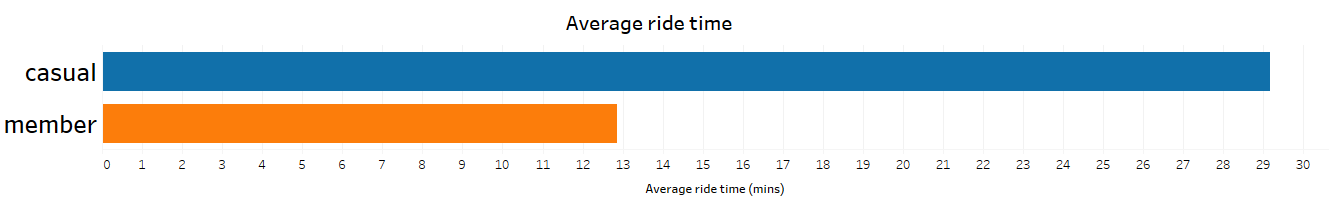

Casual riders on average, had more than twice the ride time of members. I hypothesize that casual riders are using the bikes for sight-seeing or leisure, whereas members are more likely to use the bikes to travel between train stations or homes to their workplaces.

In [ ]:
-- TOTAL RIDES BY MEMBERSHIP STATUS.

SELECT
    member_casual,
    COUNT(member_casual) AS total_rides

FROM
    merged

GROUP BY
    member_casual

(2 rows affected)

Total execution time: 00:00:00.187

member_casual,total_rides
member,3819206
casual,2765176


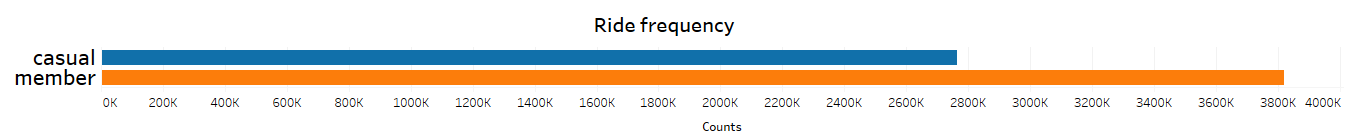  

Over the course of the year, members accounted for more trips as compared to the casual riders. This could be due to the nature of the subscription services. Customers with annual memberships may attempt to maximize value by continously using the bikes as membership grants them unlimited rides in a year.

The formation of the table for total rides grouped by weekdays in SQL is a bit complicated.

The image below shows the transition of the dataframe from the innermost to outermost queries. The same logic is applied when investigating the ride frequencies in different months and hours.

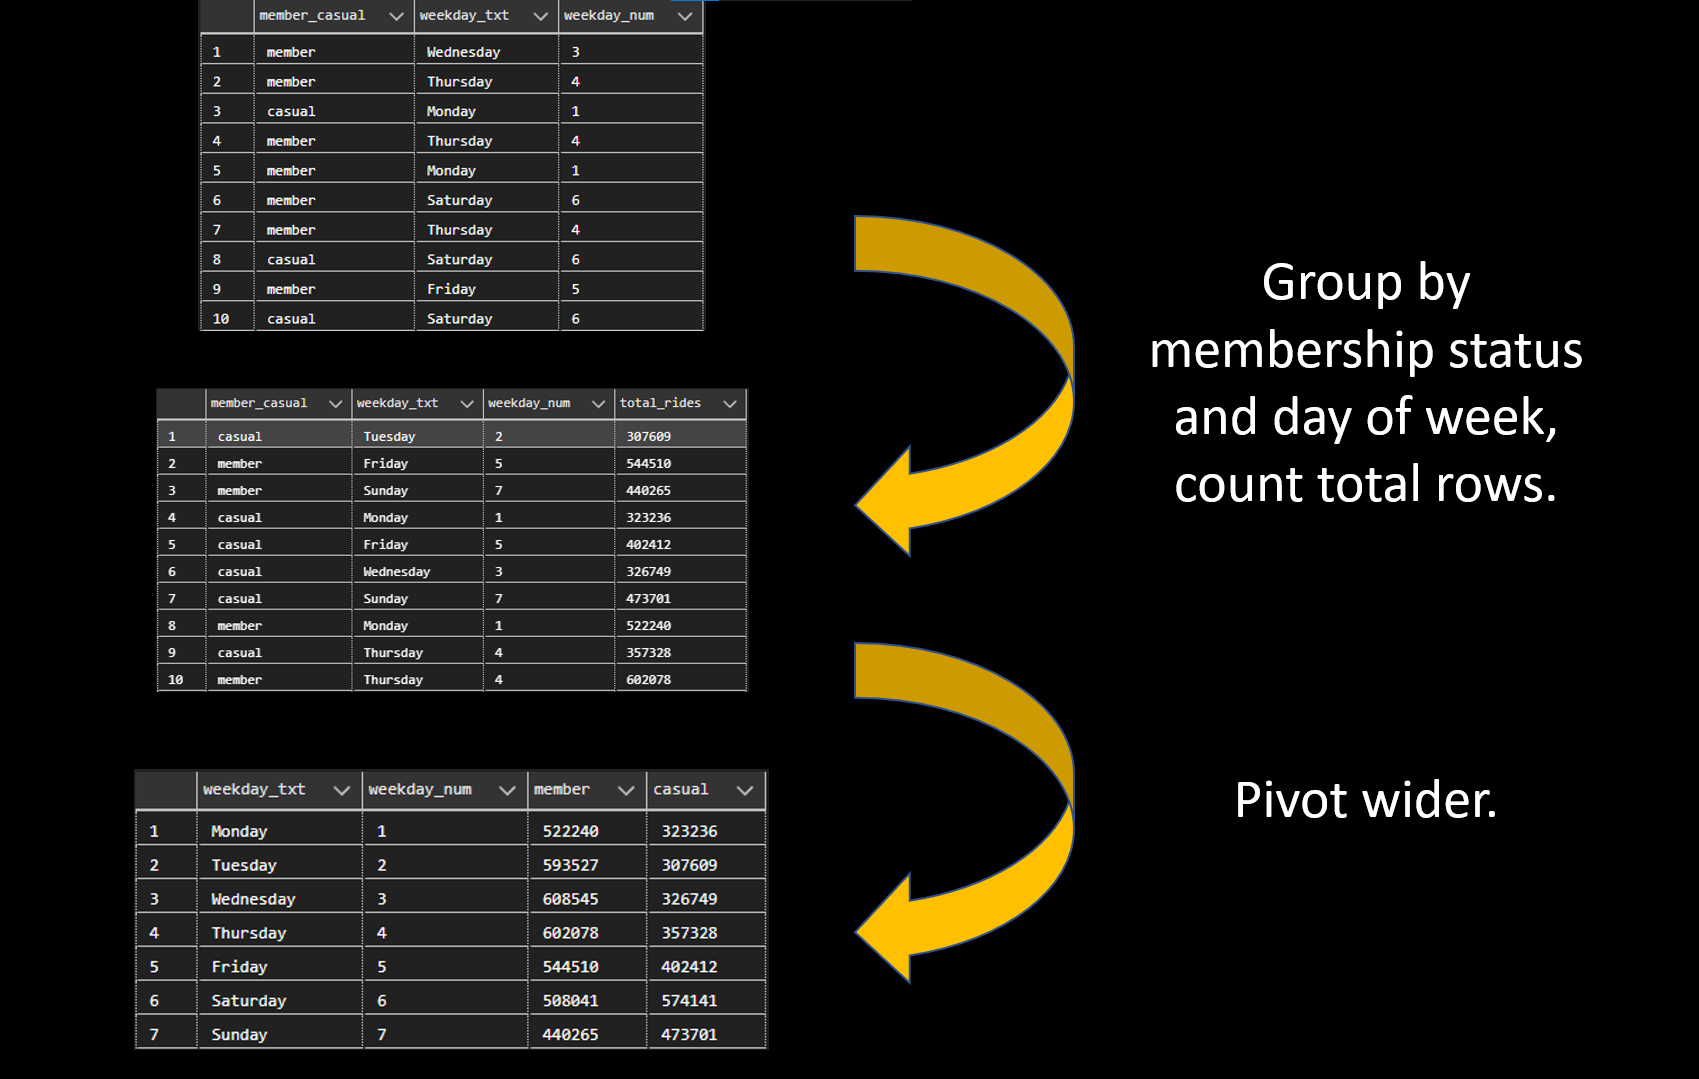

In [ ]:
-- RIDE FREQUENCY BY WEEKDAYS.

-- The command below makes it so that the first day of the week is Monday.
-- Failure to do so causes Sunday to be the first day (US English default), causing errors in the table.
SET DATEFIRST 1;

-- Pivot_wider. GROUP BY weekdays, aggregate the member and casual columns using CASE WHEN and conditions.
SELECT
    weekday_txt,
    weekday_num,
    SUM(CASE WHEN member_casual = 'casual' THEN total_rides END) AS casual,
    SUM(CASE WHEN member_casual = 'member' THEN total_rides END) AS member

FROM (
    -- This inner query aggregates the number of rides in each weekday for each membership status.
    SELECT
        member_casual,
        weekday_txt,
        weekday_num,
        COUNT(weekday_txt) AS total_rides
    FROM (
        -- This inner query produces 3 cols: membership status, weekday in text form, weekday in numeric form.
        SELECT
            member_casual,
            -- Obtain the weekday from the datetime value in the form of both text and numeric.
            -- The numeric value will be used for ORDER BY in the outer query.
            DATENAME(WEEKDAY, started_at) AS weekday_txt,
            DATEPART(WEEKDAY, started_at) AS weekday_num
        FROM
            merged) AS ride_freq
    GROUP BY
        member_casual,
        weekday_txt,
        weekday_num) AS ride_freq
GROUP BY
    weekday_txt,
    weekday_num
ORDER BY
    weekday_num

Warning: Null value is eliminated by an aggregate or other SET operation.

(7 rows affected)

Total execution time: 00:00:00.449

weekday_txt,weekday_num,casual,member
Monday,1,323236,522240
Tuesday,2,307609,593527
Wednesday,3,326749,608545
Thursday,4,357328,602078
Friday,5,402412,544510
Saturday,6,574141,508041
Sunday,7,473701,440265


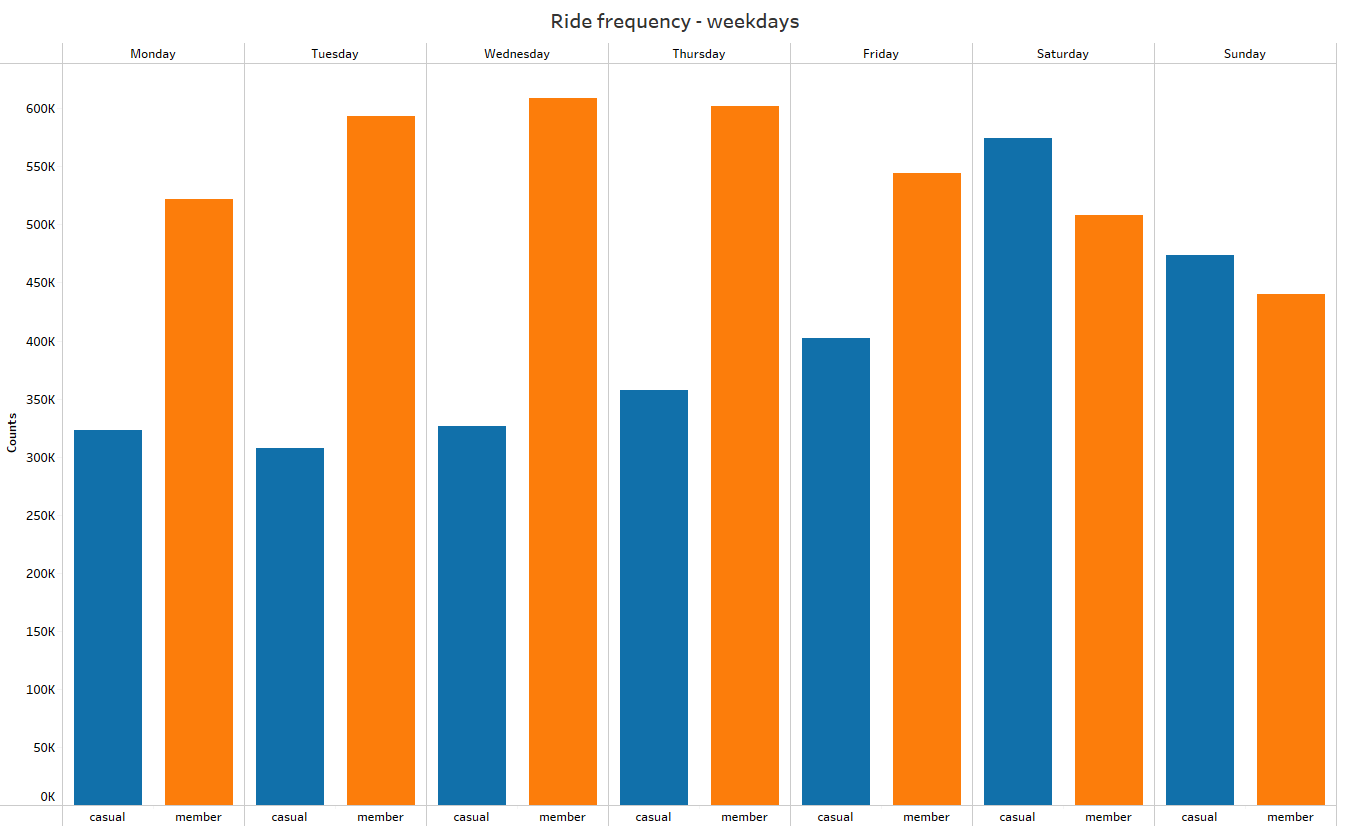

In terms of weekday ride frequencies, members had higher ride frequency during the weekdays. However on the weekends, the reverse was true - casual riders had greater ride frequency than members. This further supports the hypothesis that casual riders were using the bikes for leisure while members mainly used it for their commute to and from work.

In [ ]:
-- RIDE FREQUENCY BY MONTHS.

-- Pivot wider, GROUP BY month_txt and month_num, aggregate the total number of rides based on membership status.
SELECT
    month_txt,
    month_num,
    SUM(CASE WHEN member_casual = 'member' THEN total_rides END) AS member,
    SUM(CASE WHEN member_casual = 'casual' THEN total_rides END) AS casual
FROM (
    -- This query counts the total number of rides per month.
    SELECT
        member_casual,
        month_txt,
        month_num,
        COUNT(member_casual) AS total_rides
    FROM (
        -- Inner query produces membership status, month in text and month in number form.
        SELECT
            member_casual,
            DATENAME(month, started_at) AS month_txt,
            DATEPART(month, started_at) AS month_num
        FROM merged) AS month_table
    GROUP BY
        member_casual,
        month_txt,
        month_num) AS month_table
GROUP BY
    month_txt,
    month_num
ORDER BY
    month_num


Warning: Null value is eliminated by an aggregate or other SET operation.

(12 rows affected)

Total execution time: 00:00:00.346

month_txt,month_num,member,casual
January,1,85250,18520
February,2,94193,21416
March,3,194160,89882
April,4,244832,126417
May,5,354443,280415
June,6,400153,369051
July,7,417433,406055
August,8,427008,358924
September,9,796899,660587
October,10,373984,257242


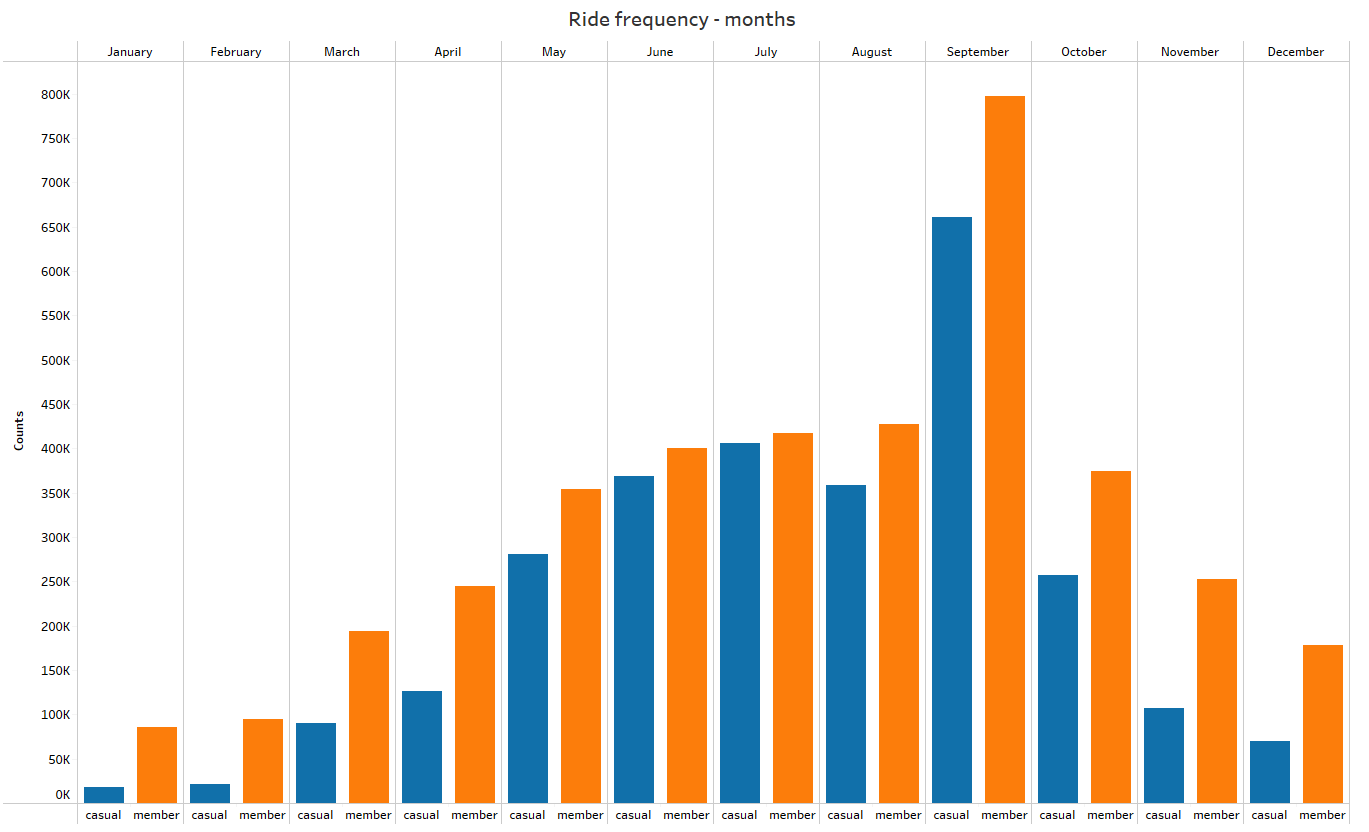

The shape of this plot is interesting. In the months of December to February, ridership levels are low compared to the rest of the year before picking up again in March. This period of low ridership corresponds to the winter period in Chicago. The minimum temperature can dip to -9°C,  so customers may not be keen to cycle during the winter. The month of September is the most popular time for bike rides. This coincides with the start of the Autumn months, which is said to be the most popular season for both locals and travellers alike.

In [ ]:
-- RIDE FREQUENCY BY HOURS.

SELECT
    -- Pivot the table from the inner query - makes it more human-readable.
    hour_of_ride,
    SUM(CASE WHEN member_casual = 'member' THEN total_rides END) AS member,
    SUM(CASE WHEN member_casual = 'casual' THEN total_rides END) AS casual

FROM (
    -- This query counts the number of rides taken by each member/casual for every hour of the day.
    SELECT
        hour_of_ride,
        COUNT(hour_of_ride) AS total_rides,
        member_casual

    FROM (
        -- This query creates a column consisting of the hour each ride begins in,
        -- in addition to the member_casual status.
        SELECT
            DATEPART(hour, started_at) AS hour_of_ride,
            member_casual
        FROM
            merged ) AS temp_hour

    GROUP BY
        hour_of_ride,
        member_casual ) AS temp_hour

GROUP BY
    hour_of_ride


Warning: Null value is eliminated by an aggregate or other SET operation.

(24 rows affected)

Total execution time: 00:00:00.345

hour_of_ride,member,casual
0,41204,56074
1,25612,36908
2,14714,23376
3,9002,13635
4,10128,9710
5,37514,14906
6,102997,33751
7,195653,60549
8,230370,80640
9,165726,87170


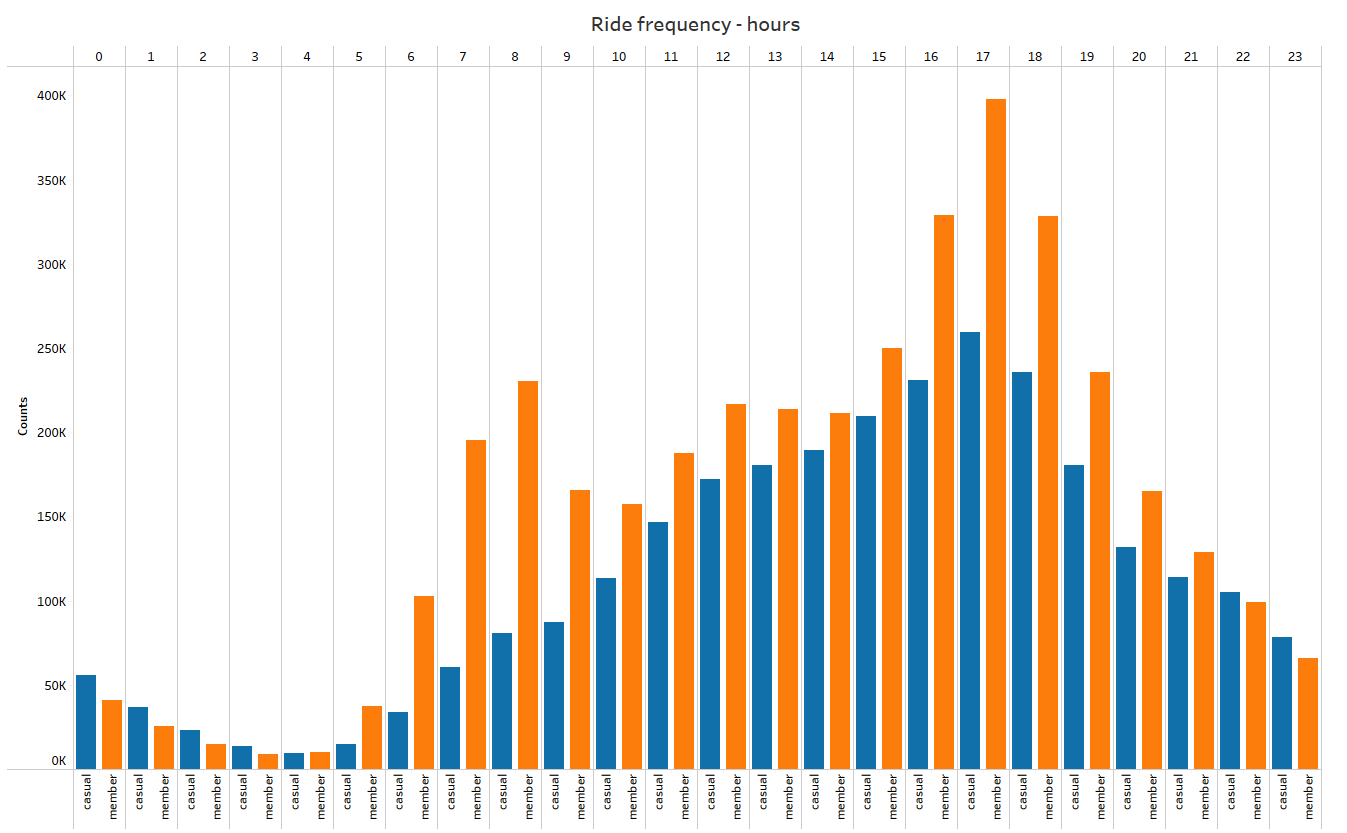

  

Ridership gradually increases as the day goes by and peaks in the evening. Interestingly, from 6-9am, the ridership of members is more than double that of the casual riders. Coupled with the peaks from 4pm to 6pm, this suggests that members are using the bikes for their work commute.

In [ ]:
-- RIDES FROM EACH START STATION, BASED ON MEMBERSHIP STATUS.

-- New table is called stations. If query is re-run and stations exists, an error is thrown.
DROP TABLE IF EXISTS stations

-- Pivot wider, make it such that membership statuses have one column each.
SELECT
    start_station_name,
    SUM(CASE WHEN member_casual = 'member' THEN total_rides END) AS member,
    SUM(CASE WHEN member_casual = 'casual' THEN total_rides END) AS casual

INTO stations

FROM
    (
    -- Shows the number of rides for each membership status, for every start station.
    SELECT
        member_casual,
        start_station_name,
        COUNT(member_casual) AS total_rides
    FROM
        merged
    GROUP BY
        member_casual,
        start_station_name ) AS start_station_temp
GROUP BY
    start_station_name


SELECT TOP 100
    *
FROM stations

Warning: Null value is eliminated by an aggregate or other SET operation.

(1594 rows affected)

(100 rows affected)

Total execution time: 00:00:01.478

start_station_name,member,casual
10101 S Stony Island Ave,NULL,3
Aberdeen St & Monroe St,7990,3820
Ada St & 119th St,1,2
Ashland Ave & Division St,17175,11602
Avenue J & 112th St,1,3
Broadway & Barry Ave,20363,14380
Broadway & Thorndale Ave,4973,3320
Buckingham Fountain (Temp),832,1605
Budlong Woods Library,784,561
California Ave & Devon Ave - NW,6,5


In [ ]:
-- TOP 10 STATIONS FOR MEMBERS
SELECT TOP 11
    start_station_name,
    member
FROM
    stations
ORDER BY
    member DESC

(11 rows affected)

Total execution time: 00:00:00.009

start_station_name,member
,566324
Kingsbury St & Kinzie St,29027
Clark St & Elm St,25943
Wells St & Concord Ln,25558
Wells St & Elm St,22461
Clinton St & Madison St,21895
Clinton St & Washington Blvd,21866
Ellis Ave & 60th St,21865
University Ave & 57th St,21503
Loomis St & Lexington St,20598


In [ ]:
-- TOP 10 STATIONS FOR CASUAL RIDERS
SELECT TOP 11
    start_station_name,
    casual
FROM
    stations
ORDER BY
    casual DESC

(11 rows affected)

Total execution time: 00:00:00.020

start_station_name,casual
,421821
Streeter Dr & Grand Ave,67959
DuSable Lake Shore Dr & Monroe St,36331
Millennium Park,31262
Michigan Ave & Oak St,29736
DuSable Lake Shore Dr & North Blvd,28192
Shedd Aquarium,23421
Theater on the Lake,21525
Wells St & Concord Ln,19916
Clark St & Armitage Ave,16653


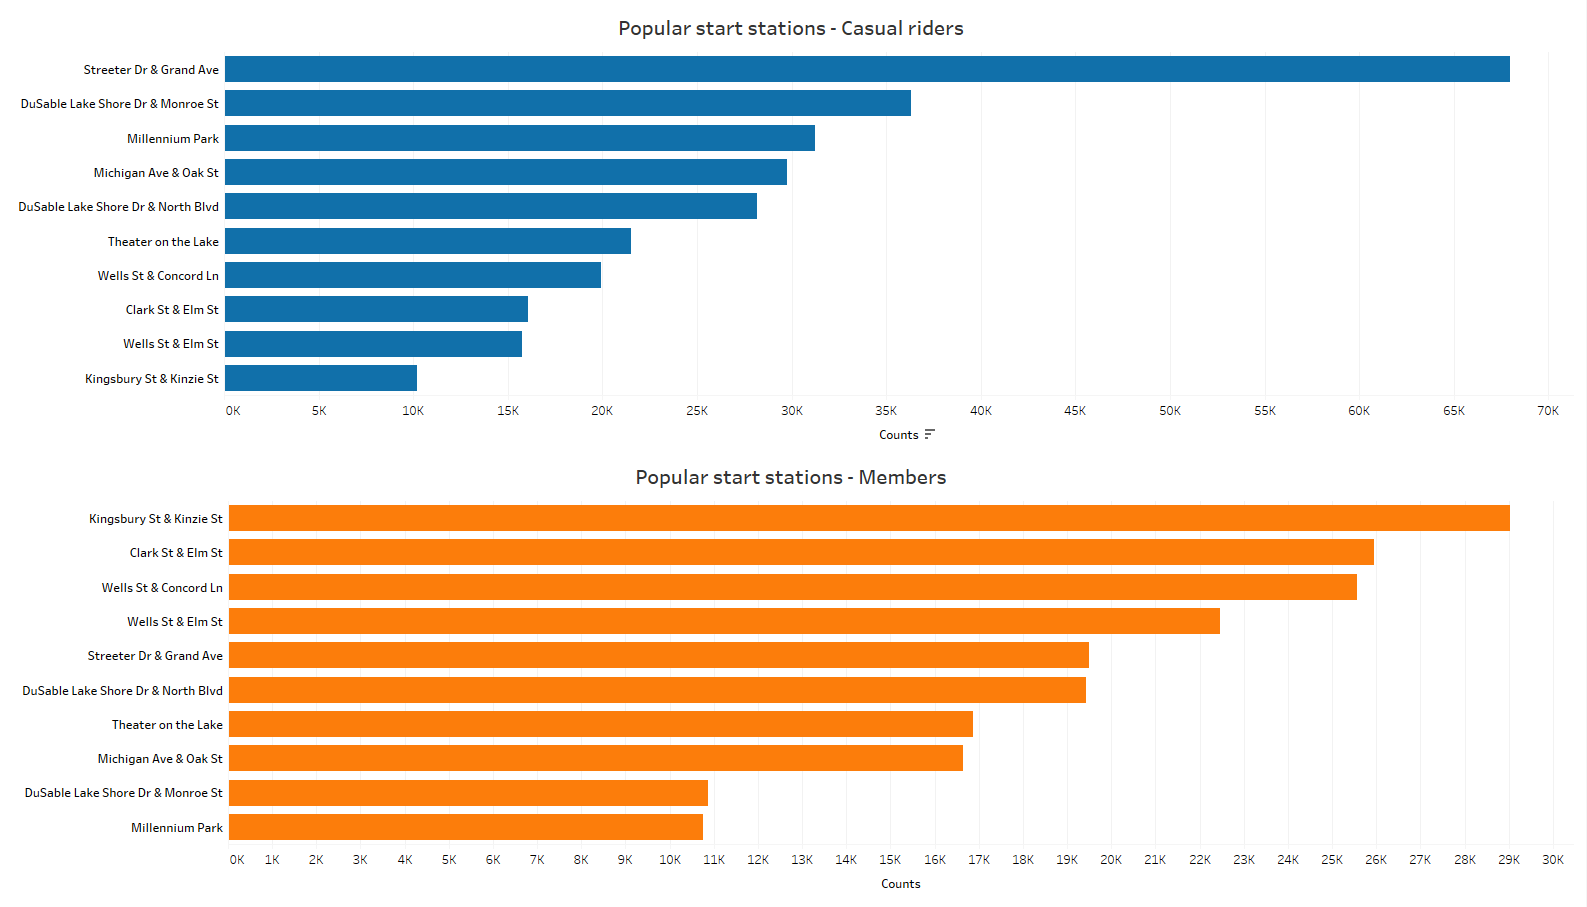

Not a lot of information can be gleaned from looking at popular start stations in a table or bar graph form, however, it is useful to know where the bulk of users are starting their riders from. In addition to advertisements on the app, it may be useful to use posters to advertise to attract new customers as well. It is important to note that there are only a few common stations in the most popular station shared between casual riders and members. This again, suggests that casual riders and members use bikes for different purposes.

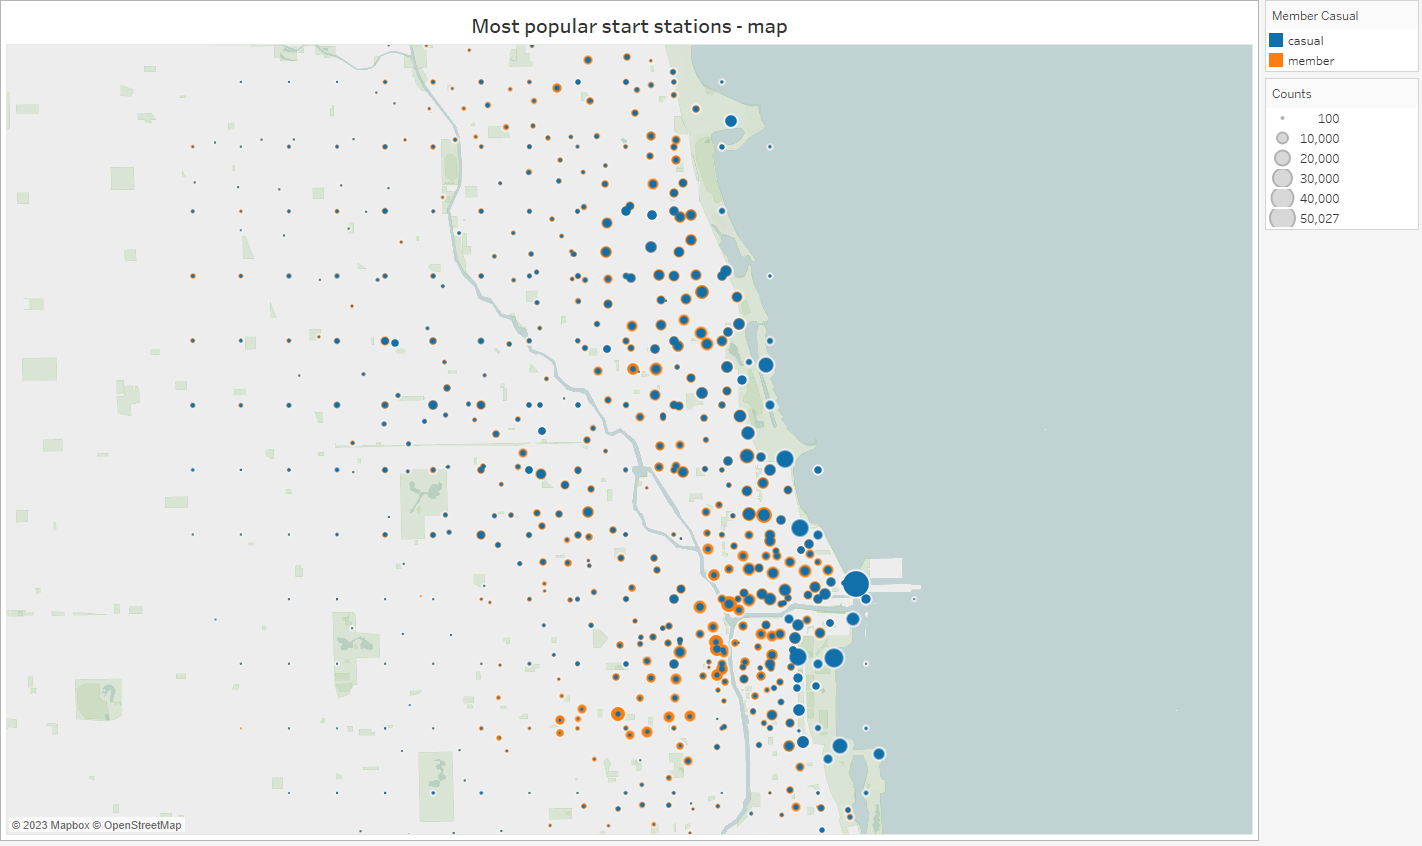

When seen on a map, we observe that the majority of casual riders have their starting stations near the Lake Michigan, whereas a sizeable portion of members have their start stations further inland. This reinforces the fact that casual riders are either tourists or travellers and using the bikes for leisure while members are using the bikes for their commute to work.

In [ ]:
-- BIKE TYPES BY MEMBERSHIP STATUS

SELECT
    member_casual,
    rideable_type,
    COUNT(rideable_type) AS rides

FROM
    merged

GROUP BY
    member_casual,
    rideable_type

ORDER BY
    member_casual,
    rideable_type


(5 rows affected)

Total execution time: 00:00:00.249

member_casual,rideable_type,rides
casual,classic_bike,1136914
casual,docked_bike,227812
casual,electric_bike,1400450
member,classic_bike,2065886
member,electric_bike,1753320


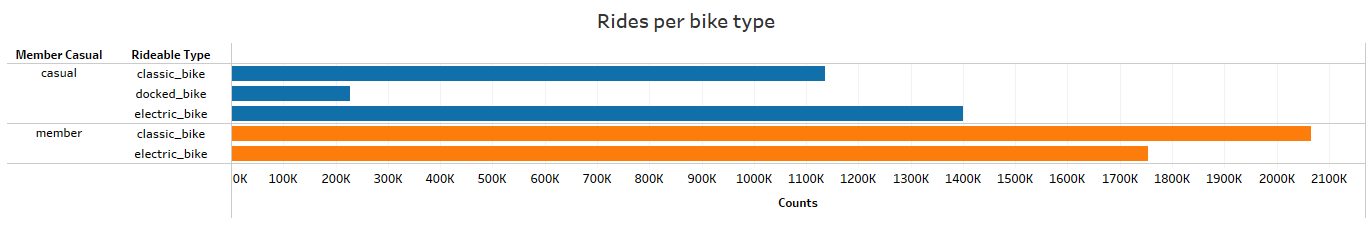

Not a lot of value can be gleaned from this graph without more information. There is no entry for docked bike usage for members. With the information we have, it seems that casual members prefer electric bikes while members prefer classic bikes although whether this is due to preference or not is uncertain. It may be due to the availability of bikes in the area.

Some distinctions can be made between the two types of members.

Casual members

- Longer ride time on average
- Use bikes on weekends rather than weekdays
- Bike usage is increased in September (Autumn)
- Are likely travellers or tourists as their starting stations are closer to Lake Michigan

Annual members

- Use bikes more frequently than casual riders
- Likely using the bikes for commute to and from work (spikes at 8am and 5pm)

Some recommendations can be made to convert casual riders to members.

- In addition to annual memberships, the company could experiment with having a less costly membership option for weekend-only users, because the number of casual riders outnumbers members during the weekends, making it wise to open a membership program to target these weekend casual riders.
- Do promotions and advertisements during weekends or the autumn season, where ridership peaks.
- Offer a discount for annual membership for first-time buyers, to incentivize the purchase of the membership.
- Reach out to competitive cyclists, and collaborate with them to make advertisements on social media platforms like Instagram, Twitter and TikTok.

As a side note, Cyclistic should offer a full-week pass as some travellers may only be in the region for a few days or a week. Although they will not be annual members, it may be worth targetting these users for some additional profit.